In [1]:
%matplotlib widget
import numpy as np
import json
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display

from alvra_tools.load_data import *
from alvra_tools.load_meta import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm, threshold
import glob
from alvra_tools.YAG_scans import *
from ipyfilechooser import FileChooser

import warnings
warnings.filterwarnings('ignore')

In [39]:
pgroup='p20268'
runnumber = 5
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
jsonfile

run: 0005


'/sf/alvra/data/p20268/raw/run0005-KnifeEdgeX/meta/scan.json'

In [28]:
#fc = FileChooser('/sf/alvra/data/p19638/raw/')
#fc.use_dir_icons = True
#display(fc)

In [40]:
quantile_band = 1

channel_list = [channel_diode_1,channel_Izero110]

################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
Position_mm = scan.readbacks

Signal = []
Izero117 = []
Izero122 = []

for i, step in enumerate(scan):
    check_files_and_data(step)
    clear_output(wait=True)
    filename = scan.files[i][0].split('/')[-1].split('.')[0]
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
    
    results,pids = load_data_compact(channel_list, step)
    
    shots_even = pids%2 == 0
    shots_odd = pids%2 != 0
    
    Izero117_shot = results[channel_Izero110]#[shots_even]
#    Izero122_shot = results[channel_Izero122]#[shots_even]
    signal_shot = results[channel_diode_1]#[shots_even]
    
    signal_norm_shot = signal_shot #/ Izero117_shot              #Normalization with PBPS117
#     signal_norm_shot = signal_shot / Izero122_shot              #Normalization with PBPS122
            
    df_signal = pd.DataFrame(signal_norm_shot)
    Signal.append(np.nanquantile(df_signal, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
    
#    df_Izero117 = pd.DataFrame(Izero117_shot)
#    Izero117.append(np.nanquantile(df_Izero117, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
    
    df_Izero122 = pd.DataFrame(Izero122_shot)
    Izero122.append(np.nanquantile(df_Izero122, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

Position_mm = Position_mm[:np.shape(Signal)[0]]
Signal = np.asarray(Signal)
Izero117 = np.asarray(Izero117)
Izero122 = np.asarray(Izero122)

print ("Job done!")
print ('Quantiles for error bars: {},{}'.format(0.5 - quantile_band/2, 0.5 + quantile_band/2))

Step 76 of 76: Processing acq0076

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet   251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET  251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY 250 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 250 / 251 -> 0% loss
complete channels: 2 / 3 -> 33% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Job done!
Quantiles for error bars: 0.0,1.0


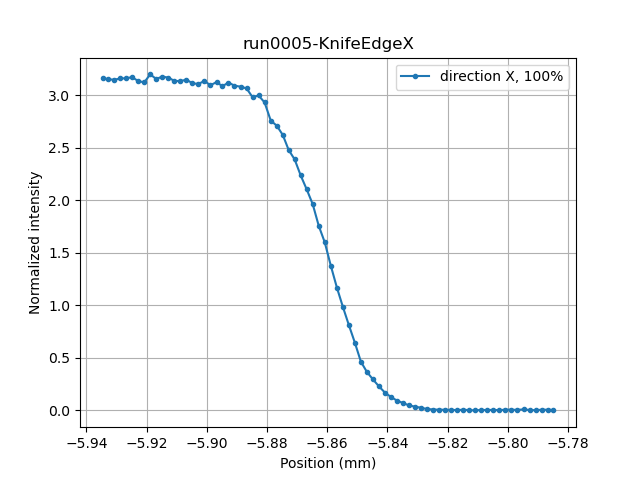

In [41]:
Int = Signal[:,0]
err_low = Signal[:,1]
err_high = Signal[:,2]

plt.figure()
plt.plot(Position_mm, Int, label='direction X, {}%'.format(quantile_band*100),marker='.')
#plt.fill_between(Position_mm, err_low, err_high, color='lightblue')

plt.title(jsonfile.split('/')[-3])
plt.ylabel('Normalized intensity')
plt.xlabel("Position (mm)")
plt.legend(loc="best")
plt.grid()

plt.show()

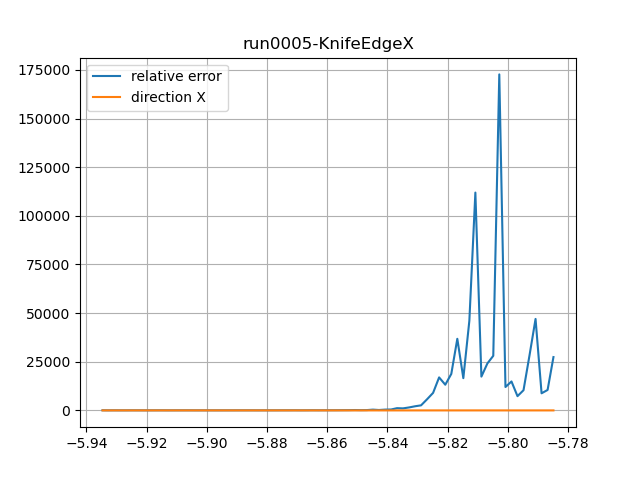

In [42]:
point = 12

band = Signal[:,2] - Signal[:,1]
value = Signal[:,0]
#print(band, value) 
#print(band/abs(value)*100)
plt.figure()
plt.title(jsonfile.split('/')[-3])
plt.plot(Position_mm,band/abs(value)*100, label = 'relative error')
plt.plot(Position_mm, Int, label = 'direction X')
plt.legend(loc='best')
plt.grid()

In [43]:
# err function ---------------> [x0, amplitude, width, offset]

fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
fit.estimate(Position_mm, Int)            # this sets some internal params 

#fit.p0 = better_p0(fit.p0, 0, -7.6) # overwrite some values (index) if needed: 

fit.fit(Position_mm,Int)                  # calculate the fit
ke_fit = fit.eval(Position_mm)           # evaluate the curve for plotting

centerpos_mm = fit.popt[0]
width_mm = fit.popt[2]

print("Position t0 =",np.round(centerpos_mm,5),"mm")
print("Width =",np.abs(np.round(width_mm,5)*1000),"mm")

Position t0 = -5.86128 mm
Width = 31.08 mm


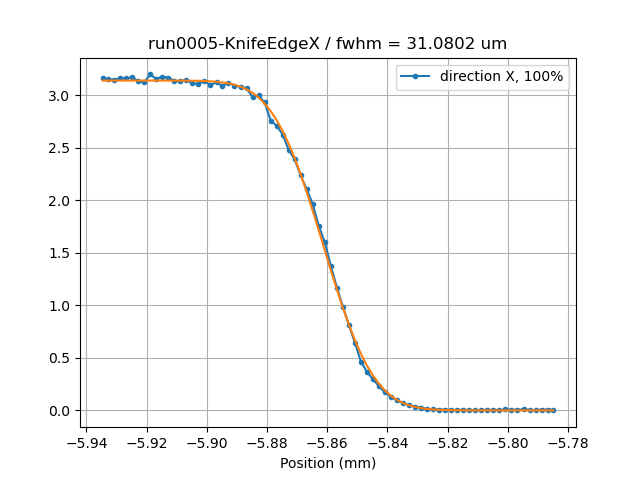

In [44]:
#... and the plot with the fit curve
plt.figure()

plt.plot(Position_mm, Int, label='direction X, {}%'.format(quantile_band*100),marker='.')
#plt.fill_between(Position_mm, err_low, err_high, color='lightblue')
plt.plot(Position_mm, ke_fit)

plt.title(jsonfile.split('/')[-3] + ' / fwhm = {} um'.format(np.round(np.abs(width_mm)*1000, 4)))
#plt.title("X direction")
plt.grid()
plt.xlabel("Position (mm)")
plt.legend(loc="best")
plt.show()
#plt.savefig(savedir + 'scan_LAM_003')